# Possion and Zero-Inflated Possion Models Fitting

## 1. Normal Possion model

The Possion distribution describes discrete counts, like number of cars passes through a toll station or number of patients visiting hospital etc. Therefore, the sample is always a positive integer (zero inclusive). If $X=\lbrace x_1, x_2, \cdots, x_n \rbrace$ forms a Poisson distribution with parameter $\lambda$, then

$$P(x) = \frac{e^{-\lambda}\lambda^x}{x!},$$

is the probability to get $x$. In a Possion distribution, both the mean value of X and variance are $\lambda$. In the following, we will show that, given a sample distribution, how to fit the Possion parameter $\lambda$.

In [60]:
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import  pyplot as plt

N = 1000
lambda_ = 3

x = stats.poisson.rvs(lambda_, size=N)

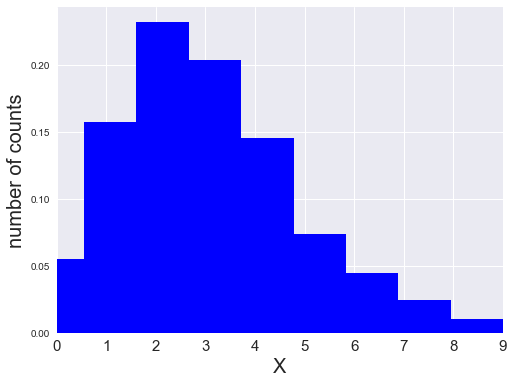

In [62]:
fig, ax = plt.subplots(figsize=(8,6))

p1t = plt.hist(x, bins = np.linspace(-0.5, max(x), max(x)+1), color='blue', normed=True)

plt.ylabel('number of counts', fontsize=20)
plt.xlabel('X', fontsize=20)
plt.xticks(ind, fontsize=15)
plt.xlim(0, max(x))
plt.show()

9 3.11126528123


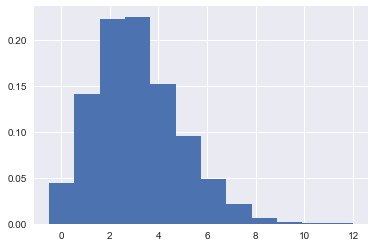

In [51]:
from scipy.optimize import curve_fit
from scipy.misc import factorial

# poisson function, parameter lamb is the fit parameter
def poisson(k, lambda_):
    return (lambda_**k/factorial(k)) * np.exp(-lambda_)


entries, bin_edges, patches = plt.hist(x, bins=np.linspace(-0.5, max(x), max(x)+1), normed=True);
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# fit with curve_fit
parameters, cov_matrix = curve_fit(poisson, bin_middles, entries) 
    
print i, parameters[0]

## 2. Zero-inflated Possion Model

In addition to the normal Possion distribution, there exists a so-called [zero-inflated Possion model](https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Zero-Inflated_Poisson_Regression.pdf). The model considers some portion as zeros, and other form a Possion distribution. Here we will follow [Austin's blog](http://austinrochford.com/posts/2015-03-03-mle-python-statsmodels.html) how to fit zero-inflated Possion model parameters.

If $X=\lbrace x_1, x_2, \cdots, x_n \rbrace$ is sampled by a zero-inflated Poisson distribution with parameters $\pi$ and $\lambda$, its probability mass function is given by

$$P(x) = \pi  + (1-\pi)\frac{e^{-\lambda}\lambda ^x}{\lambda !}.$$

The second term is regular as a normal Possion distribution. $\pi$ desribes probability for sample is chosen at zero, and $1-\pi$ describes $x$ follows a Possion distribution. We can further rewrite it as

$$P(x=0) = \pi + (1-\pi)e^{-\lambda}$$

$$P(x>0) = (1-\pi)\frac{e^{-\lambda}\lambda ^x}{\lambda !}$$

In [83]:
pi = 0.6             # probability of x = 0
p_nonzero = 1 - pi   # probability of x follows a Possion distribution
lambda_ = 3

In [53]:
def zip_pmf(x, pi=pi, lambda_=lambda_):
    if pi < 0 or pi > 1 or lambda_ <= 0:
        return np.zeros_like(x)
    else:
        return (x == 0) * pi + (1 - pi) * stats.poisson.pmf(x, lambda_)

In [91]:
inflated_zero = stats.bernoulli.rvs(p_nonzero, size=N)
print sum(inflated_zero)
x = inflated_zero * stats.poisson.rvs(lambda_, size=N)
# inflated_zero is an array where 40% (pi) is zero and 60% (1-pi) will go Possion distribution

397


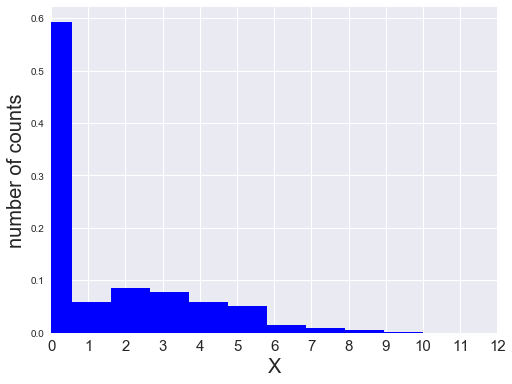

In [92]:
fig, ax = plt.subplots(figsize=(8,6))

p1t = plt.hist(x, bins = np.linspace(-0.5, max(x), max(x)+1), color='blue', normed=True)

plt.ylabel('number of counts', fontsize=20)
plt.xlabel('X', fontsize=20)
plt.xticks(ind, fontsize=15)
plt.xlim(0, 12)
plt.show()

In [99]:
from scipy import stats
from statsmodels.base.model import GenericLikelihoodModel

class ZeroInflatedPoisson(GenericLikelihoodModel):
    def __init__(self, endog, exog=None, **kwds):
        if exog is None:
            exog = np.zeros_like(endog)
            
        super(ZeroInflatedPoisson, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        pi = params[0]
        lambda_ = params[1]

        return -np.log(zip_pmf(self.endog, pi=pi, lambda_=lambda_))
    
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):                
        if start_params is None:
            lambda_start = self.endognloglikeobs.mean()  ## start_lambda, E(x) = lambda
            excess_zeros = (self.endog == 0).mean() - stats.poisson.pmf(0, lambda_start)  ## start
            
            start_params = np.array([excess_zeros, lambda_start])
        
        return super(ZeroInflatedPoisson, self).fit(start_params=start_params,
                                                    maxiter=maxiter, maxfun=maxfun, **kwds)

The `ZeroInflatedPoisson` class inherits from [`GenericLikelihoodModel`](http://www.statsmodels.org/dev/_modules/statsmodels/base/model.html#GenericLikelihoodModel). The method `nloglikeobs` returns the negative log likelihood of each observed value in `endog`. To fit the zero-inflated Possion model, the likelidhood is written as

$$l(\pi, \lambda)= \Pi^N_{i =1} P(x=x_i)=\Pi^N_{i=1} \Big( \pi + (1-\pi)e^{-\lambda} \Big)^{x_i=0} \Big((1-\pi)\frac{e^{-\lambda}\lambda ^x}{\lambda !} \Big)^{x_i >0}.$$

The log likelihood is weitten as 
$$\log l(\pi, \lambda)= \sum\limits_{x_i=0} \log\Big( \pi + (1-\pi)e^{-\lambda} \Big) + \sum\limits_{x_i>0}\log\Big((1-\pi)\frac{e^{-\lambda}\lambda ^x}{\lambda !} \Big).$$

The `GenericLikelihoodModel` will minimizing the log likelidhood to find optimal fit ZIP parameters $\pi$ and $\lambda$.

In [100]:
model = ZeroInflatedPoisson(x)
results = model.fit()

None
Optimization terminated successfully.
         Current function value: 1.365980
         Iterations: 41
         Function evaluations: 76


In [96]:
results.params

array([ 0.6034378 ,  3.06122227])